In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as  SFS

# Results for California data

In [2]:
# Open data
from sklearn.datasets import fetch_california_housing
california_housing_data = fetch_california_housing()
X, y = california_housing_data.data, california_housing_data.target
feature_names = np.asarray(california_housing_data.feature_names)

We first define the "pipeline", i.e., the different steps we want to process our data. 

First the feature are scaled, and we apply a forward feature selection before using a linear model for regression. 

In [3]:
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("feature_selector", SFS(LR())),
    ("lr", LR())])

We now define the dictionary containing the parameters of our pipeline/model to be optimized during the cross validation. Note here that the LR use for the SFS has default value. It is not yet possible to provide values during the GCV.

In [4]:
params_grid = {
    "feature_selector__n_features_to_select": [3, 4, 5, 6],
}

In [5]:
err = []
n_feature = []
for random_state in range(25):
    print(random_state, "\r")
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)
    
    # GCV
    grid = GridSearchCV(model, param_grid=params_grid, cv= 5,
                        refit=True, n_jobs=-1) # Do the grid search in parallel
    grid.fit(X_train, y_train) # Run the grid search
    
    # Score & n_feature
    err.append(grid.best_estimator_.score(X_test, y_test))
    n_feature.append(grid.best_estimator_.named_steps["feature_selector"].n_features_to_select_)

0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 


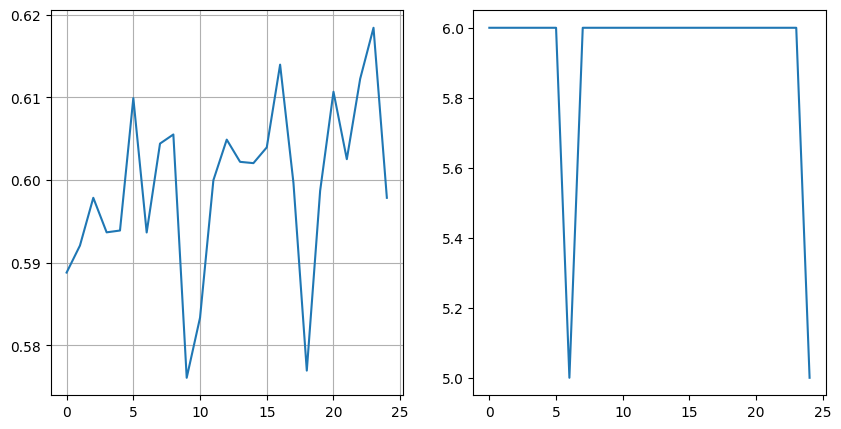

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].plot(err)
axs[0].grid("on")
axs[1].plot(n_feature)

In [10]:
best_last_model = grid.best_estimator_
print(best_last_model.named_steps["feature_selector"].n_features_to_select_)
print(f"""Feature selected: {feature_names[best_last_model.named_steps["feature_selector"].get_support()]}""")

5
Feature selected: ['MedInc' 'HouseAge' 'AveBedrms' 'Latitude' 'Longitude']


# Restults for Digits Data
In this section, we won't repeat the learning of the pipeline presented in the previous section. The objective here is to check if the retuned feature using SFS is interpretable. I recall that the input features of the digits data set are pixels. Hence, selected feature by SFS will be the pixels of the image that are the most helpfull for the classification task, i.e., the most discriminative.

In [11]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

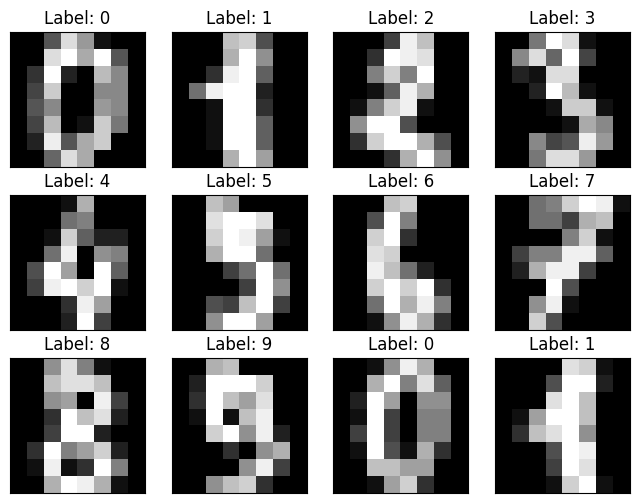

In [12]:
# Plots some samples with all feature
ig, axs = plt.subplots(nrows=3, ncols=4, figsize=(8, 6))
plt.gray()
for i in range(3):
    for j in range(4):
        axs[i, j].matshow(X[i*4+j, :].reshape(8, 8),  cmap='gray')
        axs[i, j].tick_params(axis=u'both', which=u'both',length=0)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_title(f"Label: {y[i*4+j]}")

We will select the optimal number of feature to keep using cross-validation. To save time we will do only one split, but ideally, it should have been done several times.

In [13]:
# Define pipeline as usual
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("feature_selector", SFS(RFC(n_estimators=10))),
    ("RFC", RFC(n_estimators=10))])

params_grid = {"feature_selector__n_features_to_select": range(5, 41, 5)}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
# GCV
grid = GridSearchCV(model, param_grid = params_grid, cv = 5, n_jobs = -1) # Do the grid search in parallel
grid.fit(X_train, y_train) # Run the grid search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector',
                                        SequentialFeatureSelector(estimator=RandomForestClassifier(n_estimators=10))),
                                       ('RFC',
                                        RandomForestClassifier(n_estimators=10))]),
             n_jobs=-1,
             param_grid={'feature_selector__n_features_to_select': range(5, 41, 5)})

we can plot CV score for the investigated parameters. A too low number of features (<20) does not provide good scores, and the best result are obtained with 40 features. Hence, 40 pixels among 64 are necessary. 

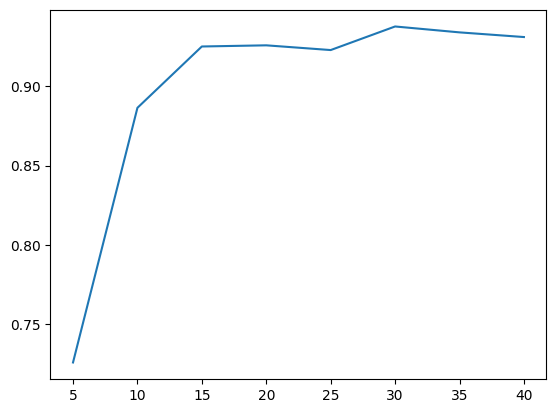

In [15]:
plt.plot(params_grid["feature_selector__n_features_to_select"], grid.cv_results_["mean_test_score"])

My guess is that pixels at the border of the image are rarely touch by the pencil and thus won't be selected. Let's check that by plotting the selected features/pixels.

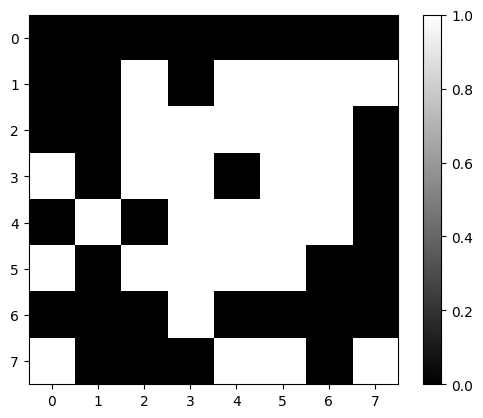

In [16]:
# Get the index of selected pixels
model = grid.best_estimator_
ind = model.named_steps["feature_selector"].get_support()

# Create a dummy image of size 8*8 and plot it
im = np.zeros((8*8))
im[ind] = 1
im.shape = (8,8)
plt.imshow(im)
plt.colorbar()

My guess is wrong ! But to be more robust, the analysis should have been repeated several times with different split ... Here, the selected feature are conditionned to the training samples.